In [20]:
# Load Data
import pandas as pd
data = pd.read_csv('titanic_data.csv')
Data = data.drop(['Survived'], axis=1).values
Y = data['Survived'].values
feature_name = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']

In [21]:
# One-Hot Encoding
import numpy as np
def One_Hot_Encode(x, j = -1):
    x = x.tolist()
    # Transformation for Pclass
    x[0] = np.identity(3)[int(x[0]-1)].tolist()
    # Transformation for Sex
    x[1] = np.identity(2)[int(x[1])].tolist()
    # Transformation for Age
    bins = np.linspace(0, 81, 5)
    binning = np.digitize(x[2], bins) - 1
    x[2] = np.identity(len(bins)-1)[binning].tolist()
    # Transformation for Siblings/Spouses Aboard
    x[3] = np.identity(9)[int(x[3])].tolist()
    # Transformation for Parents/Children Aboard
    x[4] = np.identity(7)[int(x[4])].tolist()
    # Transformation for Fare
    bins = np.linspace(0, 50, 6).tolist() + np.linspace(70, 520 , 11).tolist()
#     bins = np.linspace(0, 520, 26).tolist()
    binning = np.digitize(x[5], bins) - 1
    x[5] = np.identity(len(bins)-1)[binning].tolist()
    if j >= 0:
        x.pop(j)
    return x
# Encode
DATA = []
for x in Data:
    DATA.append(One_Hot_Encode(x))

In [22]:
import math
# j-feature Entropy on dataset
def Entropy(j, dataset):
    # get the j-th col
    X = np.array([x[j] for x in dataset])
    num = len(X)
    Pr = sum(X)/num
    ans = 0
    for p in Pr:
        if p > 0:
            ans = ans - p * math.log(p)
    return ans
# Entropy of Y
def Entropy_Y(label):
    p = sum(label) / len(label)
    if p == 0 or p == 1:
        return 0
    ans = (1-p) * math.log(1-p) - p * math.log(p)
    return ans

In [23]:
# Split label and dataset with y = val
def Split_Y(val, dataset, label):
    new_Y = []
    new_DATA = []
    for i in range(len(label)):
        if label[i] == val:
            new_DATA.append(dataset[i])
            new_Y.append(label[i])
    return new_Y, new_DATA

# new_Y, new_DATA = Split_Y(0, DATA, Y)
    
# Split dataset with j-th feature = val
def Split(j, val, dataset, label):
    new_Y = []
    new_DATA = []
    for i in range(len(label)):
        if dataset[i][j][val] == 1:
            new_Y.append(label[i])
            new_DATA.append(dataset[i])
    return new_Y, new_DATA

# new_Y, new_DATA = Split(0, 0, DATA, Y)

In [24]:
# Conditional Entropy
def H(j, dataset, label):
    p = sum(label) / len(label)
    if p == 0 or p == 1:
        return 0
    new_Y, new_DATA = Split_Y(0, dataset, label)
    H0 = Entropy(j, new_DATA)
    new_Y, new_DATA = Split_Y(1, dataset, label)
    H1 = Entropy(j, new_DATA)
    ans = (1-p) * H0 + p * H1
    return ans
# Mutual Information
def I(j, dataset, label):
    return Entropy(j, dataset) - H(j, dataset, label)

In [25]:
# List Mutual Information
def List_I(dataset, label):
    LIST = [I(j, dataset, label) for j in range(len(dataset[0]))]
    return LIST

# List_I(DATA, Y)

In [26]:
class Node:
    def __init__(self, index, vals, depth, feature_name):
        self.feature_index = index
        self.values = vals
        self.sub = []
        if index == -1:
            self.predict = vals
        self.depth = depth
        if index >= 0:
#             print(index)
            self.feature_name = feature_name[index]
        else:
            self.feature_name = 'Prediction'

In [27]:
# Build a Tree
def ID3(dataset, label, depth = 0, epsilon = 1e-2, alpha = 0.05, Feature_name = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']):
    # Stop condition
    if Entropy_Y(Y) < epsilon or len(label) < alpha * data.shape[0] or depth >= len(Data[0]) - 1:
#     if Entropy_Y(Y) < epsilon or len(label) < alpha * data.shape[0]:
        p = sum(label) / len(label)
        if p >= 0.5:
            node = Node(-1, 1, depth, Feature_name)
        else:
            node = Node(-1, 0, depth, Feature_name)
        return node
    # Find node feature
    Mutual_Information = List_I(dataset, label)
    j = Mutual_Information.index(max(Mutual_Information))
    vals = len(dataset[0][j])
    node = Node(j, vals, depth, Feature_name)
    # Iterate all subtrees
    for value in range(vals):
        # split data with j-th feature = value
        new_Y, new_DATA = Split(j, value, dataset, label)
        if len(new_Y) == 0:
            node.sub.append(Node(-1, 0, depth, Feature_name))
            continue
        node.sub.append(ID3(new_DATA, new_Y, depth+1, Feature_name = Feature_name))
    return node
T = ID3(DATA, Y, depth = 0)

In [28]:
# Display the Tree
def PrintTree(Tree, indent = ''):
    if Tree.feature_index < 0:
        if Tree.values == 1:
            prediction = 'True'
        else:
            prediction = 'False'
        print(indent+'|'+prediction+'|*')
        return
    print(indent+'|-'+Tree.feature_name+'-|')
    indent = ' ' * (3+len(indent+Tree.feature_name))
    for sub in Tree.sub:
        PrintTree(sub, indent)
    return
PrintTree(T)

|-Sex-|
      |-Fare-|
             |-Pclass-|
                      |False|*
                      |False|*
                      |-Age-|
                            |-Parents/Children Aboard-|
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                            |-Siblings/Spouses Aboard-|
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |F

In [29]:
# Prediction
def Predict(x, Tree, j = -1):
    x = One_Hot_Encode(x, j)
#     print(x)
    while Tree.feature_index >= 0:
        index = Tree.feature_index
        Next = x[index].index(1)
        Tree = Tree.sub[Next]
    return Tree.values

In [30]:
# K-Fold Cross-Validation

# split all data into K subsets, return kth subset (testing, training)
def Split_Data(K, dataset, label, kth):
    # generate divide list
    sample_num, feature_num = dataset.shape
    divide = np.linspace(0, sample_num, K+1).tolist()
    for i in range(len(divide)):
        divide[i] = round(divide[i])
    # get the kth testing subsets
    testing_data = dataset[divide[kth]:divide[kth+1]]
    testing_label = label[divide[kth]:divide[kth+1]]
    # get the kth training subsets                                
    training_data = [dataset[divide[i]:divide[i+1]] for i in range(K) if i != kth]
    training_label = [label[divide[i]:divide[i+1]] for i in range(K) if i != kth]
    training_data = np.concatenate(training_data)
    training_label = np.concatenate(training_label)
    return testing_data, testing_label, training_data, training_label

# testing_data, testing_label, training_data, training_label = Split_Data(5, Data, Y, 0)


def Cross_Validation(K, dataset, label):
    predict = []
    for k in range(K):
        testing_data, testing_label, training_data, training_label = Split_Data(K, dataset, label, k)
        DATA = []
        for x in training_data:
            DATA.append(One_Hot_Encode(x))
        T = ID3(DATA, training_label, depth = 0)
        predict = predict + [Predict(testing_data[i], T) for i in range(len(testing_data))]
    
    ans = [predict[i] == label[i] for i in range(len(label))]
    accuracy = sum(ans)/len(ans)
    return accuracy

Cross_Validation(10, Data, Y)

0.8128523111612176

In [31]:
# My own feature vector x
DATA = []
for x in Data:
    DATA.append(One_Hot_Encode(x))
T = ID3(DATA, Y, depth = 0)
x = np.array([1, 1, 22, 1, 0, 71.2833])
print(Predict(x, T))

1


In [32]:
# Random Forest
import random
# Random Subset
def Random_subset(dataset, label, alpha = 0.8):
    # random select index saved in sampling
    index = range(len(dataset))
    sampling = random.choices(index, k=round(alpha*len(index)))
    sampling.sort()
    random_dataset = [dataset[i] for i in sampling]
    random_label = [label[i] for i in sampling]
    return random_dataset, random_label

# random_dataset, random_label = Random_subset(DATA, Y)

def Random_Forest(dataset, label, N, alpha = 0.8):
    Forest = []
    for n in range(N):
        random_dataset, random_label = Random_subset(dataset, label, alpha)
        Tree = ID3(random_dataset, random_label, depth = 0)
        Forest.append(Tree)
    return Forest

N = 5
forest = Random_Forest(DATA, Y, N)

In [33]:
# Display the Tree
for i in range(N):
    print('---- ----', i, '---- ----')
    PrintTree(forest[i])

---- ---- 0 ---- ----
|-Sex-|
      |-Fare-|
             |-Age-|
                   |False|*
                   |-Pclass-|
                            |False|*
                            |False|*
                            |-Siblings/Spouses Aboard-|
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                                                      |False|*
                   |False|*
                   |False|*
             |-Parents/Children Aboard-|
                                       |-Age-|
                                   

In [630]:
# Random Forest Predict
def Random_forest_Predict(x, forest):
    p = [Predict(x, T) for T in forest]
    if 2*sum(p) >= len(p):
        return 1
    return 0

# Random_forest_Predict(x, forest)

In [631]:
# Random Forest Cross_Validation
def Random_forest_Cross_Validation(K, dataset, label, N):
    predict = []
    for k in range(K):
        testing_data, testing_label, training_data, training_label = Split_Data(K, dataset, label, k)
        DATA = []
        for x in training_data:
            DATA.append(One_Hot_Encode(x))
        # generate random forest
        forest = Random_Forest(DATA, training_label, N)
        predict = predict + [Random_forest_Predict(testing_data[i], forest) for i in range(len(testing_data))]
    
    ans = [predict[i] == label[i] for i in range(len(label))]
    accuracy = sum(ans)/len(ans)
    return accuracy

N = 5
Random_forest_Cross_Validation(10, Data, Y, N)

0.8060879368658399

In [632]:
# My own feature vector x
x = np.array([1, 1, 22, 1, 0, 71.2833])
print(Random_forest_Predict(x, forest))

1


In [633]:
# Random Forest - 6 Trees - excluding one feature

# Exclude jth feature
def Exclude_feature(j, dataset, label):
    part_dataset = [np.delete(x, j) for x in dataset] 
    return part_dataset, label

# j = 1
# part_dataset, part_label = Exclude_feature(j, DATA, Y)

In [638]:
def Random_Forest_Exclude_feature(dataset, label):
    Forest = []
    for j in range(6):
        part_dataset, part_label = Exclude_feature(j, DATA, Y)
        feature_name = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
        feature_name.pop(j)
#         print(feature_name)
        Tree = ID3(part_dataset, part_label, depth = 0, Feature_name = feature_name)
        Forest.append(Tree)
    return Forest

forest = Random_Forest_Exclude_feature(DATA, Y)

In [642]:
# Random Forest Exclude feature Predict
def Random_forest_Exclude_feature_Predict(x, forest):
    p = []
    for j in range(len(forest)):
        T = forest[j]
        p.append(Predict(x, T, j))
#     print(p)
    if 2*sum(p) >= len(p):
        return 1
    return 0

# x = Data[0]
# Random_forest_Exclude_feature_Predict(x, forest)

In [643]:
# Display the Tree
N = 6
for i in range(N):
    print('---- ----', i, '---- ----')
    PrintTree(forest[i])

---- ---- 0 ---- ----
|-Sex-|
      |-Fare-|
             |-Age-|
                   |-Parents/Children Aboard-|
                                             |-Siblings/Spouses Aboard-|
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                                                       |False|*
                                             |False|*
                                        

In [644]:
# Random Forest Exclude_feature Cross_Validation
def Random_forest_Exclude_feature_Cross_Validation(K, dataset, label):
    predict = []
    for k in range(K):
        testing_data, testing_label, training_data, training_label = Split_Data(K, dataset, label, k)
        DATA = []
        for x in training_data:
            DATA.append(One_Hot_Encode(x))
        # generate random forest
        forest = Random_Forest_Exclude_feature(DATA, Y)
        predict = predict + [Random_forest_Exclude_feature_Predict(testing_data[i], forest) for i in range(len(testing_data))]
    
    ans = [predict[i] == label[i] for i in range(len(label))]
    accuracy = sum(ans)/len(ans)
    return accuracy

Random_forest_Exclude_feature_Cross_Validation(10, Data, Y)

0.8218714768883878

In [645]:
# My own feature vector x
x = np.array([1, 1, 22, 1, 0, 71.2833])
print(Random_forest_Exclude_feature_Predict(x, forest))

1


In [4]:
np.linspace(0, 81, 5)

array([ 0.  , 20.25, 40.5 , 60.75, 81.  ])

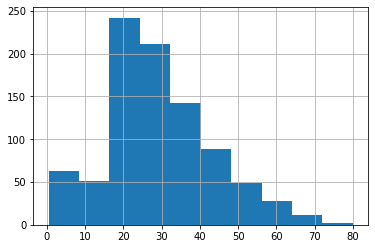

In [7]:
data['Age'].hist()

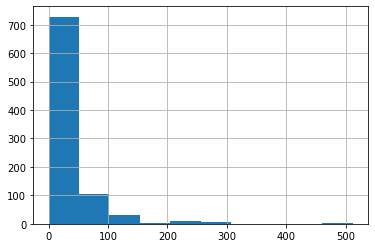

In [8]:
data['Fare'].hist()